<a href="https://colab.research.google.com/github/nabila13/BrainTumorClassification/blob/main/BTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
seed = 0
import warnings
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
IMG_SIZE = 255
x_train = []
y_label = []

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/BTCdataset'):
    print(dirname)
    for filename in filenames:
        im = cv2.imread(dirname+"/"+filename)
        img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if 'tumor_no' in dirname:
            y_label.append(0)
            x_train.append(new_array)
        elif 'glioma_tumor' in dirname:
            y_label.append(1)
            x_train.append(new_array)
        elif 'meningioma_tumor' in dirname:
            y_label.append(2)
            x_train.append(new_array)
        elif 'pituitary_tumor' in dirname:
            y_label.append(3)
            x_train.append(new_array)

/content/gdrive/MyDrive/BTCdataset
/content/gdrive/MyDrive/BTCdataset/Training
/content/gdrive/MyDrive/BTCdataset/Training/pituitary_tumor
/content/gdrive/MyDrive/BTCdataset/Training/meningioma_tumor
/content/gdrive/MyDrive/BTCdataset/Training/glioma_tumor
/content/gdrive/MyDrive/BTCdataset/Training/tumor_no
/content/gdrive/MyDrive/BTCdataset/Testing
/content/gdrive/MyDrive/BTCdataset/Testing/glioma_tumor
/content/gdrive/MyDrive/BTCdataset/Testing/meningioma_tumor
/content/gdrive/MyDrive/BTCdataset/Testing/pituitary_tumor
/content/gdrive/MyDrive/BTCdataset/Testing/tumor_no


In [ ]:
x_train = np.array(x_train)
x_train.shape

(3264, 255, 255, 3)

In [ ]:
y_label = np.array(y_label)
y_label = pd.get_dummies(y_label)
y_label.shape

(3264, 4)

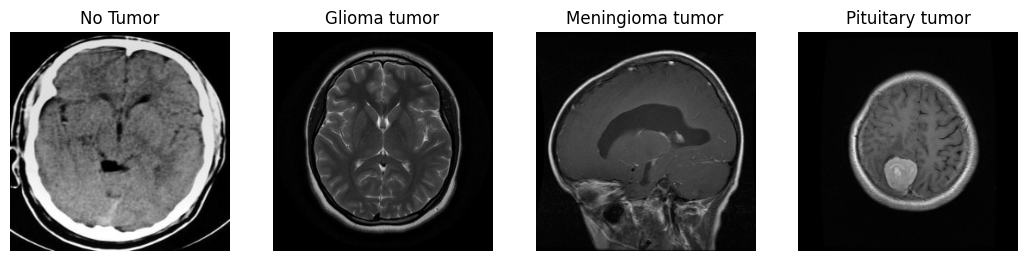

In [ ]:
fig, axes = plt.subplots(ncols=4, figsize=(13,6))
title = ["No Tumor",
         "Glioma tumor",
         "Meningioma tumor",
         "Pituitary tumor"]
for i in range(4):
    rand_ind = np.random.randint(0, y_label[y_label==i].shape[0])
    axes[i].imshow(x_train[rand_ind])
    axes[i].set_title(title[i])
    axes[i].axis('off')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x_train, y_label, test_size=0.3, random_state=seed
)

In [ ]:
X_train.shape

(2284, 255, 255, 3)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest'
                                  )

for i in range(0,2284):
    img_tensor = np.expand_dims(X_train[i], axis=0)
    pic = train_datagen.flow(img_tensor,batch_size =1, seed=0)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    X_train = np.append(X_train, [image_], axis=0)
print(image_.shape)

(255, 255, 3)


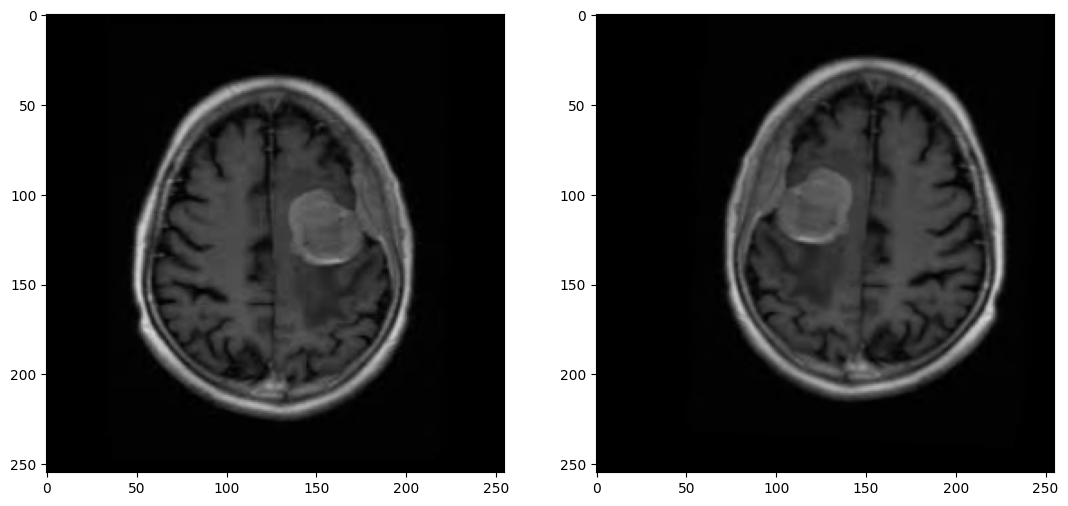

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(13,6))
axes[0].imshow(X_train[0])
axes[1].imshow(X_train[0+2284])

In [ ]:
y_train = pd.concat([y_train,y_train])
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_train

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

#Training with MobileNetV2

In [ ]:
IMG_SIZE = 255
import tensorflow.keras as keras
model_mobilenet = keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
model_mobilenet.trainable = False
final_output = model_mobilenet.output
trainable_parameters = sum([w.shape.num_elements() for w in model_mobilenet.trainable_weights])

In [ ]:
n_layer = layers.Flatten()(final_output)
nplus_layer = layers.Dense(1024, activation="relu")(n_layer)
nplus_layer = layers.Dropout(0.5)(nplus_layer)

final_layer = layers.Dense(4, activation="sigmoid")(nplus_layer)

optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)

model_transfer_learning = keras.Model(inputs=model_mobilenet.input, outputs=final_layer)
model_transfer_learning.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 20
batch_size = 40
len(model_transfer_learning.layers)

158

In [ ]:
fine_tune_layer = 100
model_transfer_learning.trainable = True
for layer in model_transfer_learning.layers[:fine_tune_layer]:
    layer.trainable = False
len(model_transfer_learning.trainable_variables)

58

In [ ]:
model_transfer_learning.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 255, 255, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
new_model_result = model_transfer_learning.fit(X_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_split=0.2,
                         callbacks=[reduce_lr])

Epoch 1/20
92/92 [==============================] - 450s 5s/step - loss: 0.9897 - accuracy: 0.6754 - val_loss: 0.5355 - val_accuracy: 0.8053 - lr: 1.0000e-05
Epoch 2/20
92/92 [==============================] - 441s 5s/step - loss: 0.4006 - accuracy: 0.8500 - val_loss: 0.4295 - val_accuracy: 0.8381 - lr: 1.0000e-05
Epoch 3/20
92/92 [==============================] - 439s 5s/step - loss: 0.2601 - accuracy: 0.9031 - val_loss: 0.4176 - val_accuracy: 0.8403 - lr: 1.0000e-05
Epoch 4/20
92/92 [==============================] - 437s 5s/step - loss: 0.1900 - accuracy: 0.9324 - val_loss: 0.3975 - val_accuracy: 0.8403 - lr: 1.0000e-05
Epoch 5/20
92/92 [==============================] - 438s 5s/step - loss: 0.1479 - accuracy: 0.9488 - val_loss: 0.3705 - val_accuracy: 0.8709 - lr: 1.0000e-05
Epoch 6/20
92/92 [==============================] - 438s 5s/step - loss: 0.1138 - accuracy: 0.9603 - val_loss: 0.3542 - val_accuracy: 0.8796 - lr: 1.0000e-05
Epoch 7/20
92/92 [==============================] - 

In [ ]:
test_loss, test_acc = model_transfer_learning.evaluate(X_test, y_test, verbose=0)

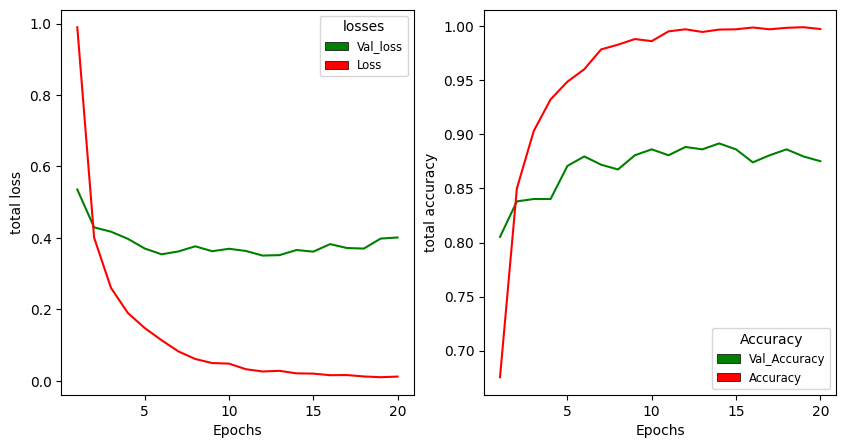

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

metrics = new_model_result.history
epochs = np.linspace(1, 20, 20)
ax1.set(xlabel='Epochs', ylabel='total loss')
ax1.plot(epochs,metrics['val_loss'], color='g')
ax1.plot(epochs,metrics['loss'], color='r')
one = mpatches.Patch(facecolor='g', label='Val_loss', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='r', label = 'Loss', linewidth = 0.5, edgecolor = 'black')
ax1.legend(handles=[one, two], title="losses",
                    loc=1, fontsize='small', fancybox=True)

ax2.plot(epochs,metrics['val_accuracy'], color='g')
ax2.plot(epochs,metrics['accuracy'], color='r')
ax2.set(xlabel='Epochs', ylabel='total accuracy')
one = mpatches.Patch(facecolor='g', label='Val_Accuracy', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='r', label = 'Accuracy', linewidth = 0.5, edgecolor = 'black')
ax2.legend(handles=[one, two], title="Accuracy",
                    loc=4, fontsize='small', fancybox=True)

#Predict new data

In [ ]:
y_pred_new = model_transfer_learning.predict(X_test)
arr = []
for item in y_pred_new:
    result = np.where(item == np.amax(item))
    arr.append(result[0][0])
y_pred_new = np.array(arr)
y_pred_new = pd.get_dummies(y_pred_new)
y_pred_new = y_pred_new.idxmax(axis=1)
y_test_new = pd.DataFrame(y_test)
y_test_new = y_test_new.idxmax(axis=1)

31/31 [==============================] - 59s 2s/step


In [ ]:
print(classification_report(np.array(y_test_new), np.array(y_pred_new), target_names=["No Tumor",
                                                                                      "Glioma Tumor",
                                                                                      "Meningioma tumor",
                                                                                      "Pituitary tumor"]))

                  precision    recall  f1-score   support

        No Tumor       0.82      0.90      0.86       145
    Glioma Tumor       0.83      0.89      0.86       254
Meningioma tumor       0.88      0.79      0.83       302
 Pituitary tumor       0.95      0.96      0.96       279

        accuracy                           0.88       980
       macro avg       0.87      0.88      0.88       980
    weighted avg       0.88      0.88      0.88       980

